In [116]:
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import bt
from bt.core import Algo
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import risk_matrix
import numpy as np
from datetime import datetime
from pandas_datareader import data as wb
import datetime as dt
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [117]:
main_tickers = ['FNTN.DE', 'NLM.F', 'MMK.VI', 'WIE.VI', 'FHZN.SW', 'KP5.F', 'LXS.DE', 'TGYM.MI', 'NDX1.DE', '39K.F', 'MOR.DE'] # ,'TMV.DE' #Data is imported from yahoo finance in the currency stated there
#main_tickers = ['VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV'] #US factor portfolio
#main_tickers = ['IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV'] #International factor portfolio 
#main_tickers = ['IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV', 'VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV'] # US + International Factor portfolio 
benchmark = ['EUMD.L'] # FS Invest portfolio 
#benchmark = ['SPY'] #US Factor portfolio 
#main_benchmark_tickers = ['SPY', 'IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV', 'VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV' ] Factor portfolio 
main_benchmark_tickers = ['EUMD.L', 'FNTN.DE', 'NLM.F', 'MMK.VI', 'WIE.VI', 'FHZN.SW', 'KP5.F', 'LXS.DE', 'TGYM.MI', 'NDX1.DE', '39K.F', 'MOR.DE','TMV.DE'] #FS invest portfolio
today = dt.date.today()
start_date_input = today - dt.timedelta(days=365*5) #importing data five years back 



In [118]:
def import_stock_data(tickers, start, end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

plot_data = import_stock_data(tickers = main_benchmark_tickers, start = start_date_input).dropna()

data = import_stock_data(tickers = main_tickers, start = start_date_input).dropna()

data_benchmark = import_stock_data(tickers = benchmark, start = start_date_input).dropna().truncate('2020-10-22') #Truncate data depending on the start of backtesting 


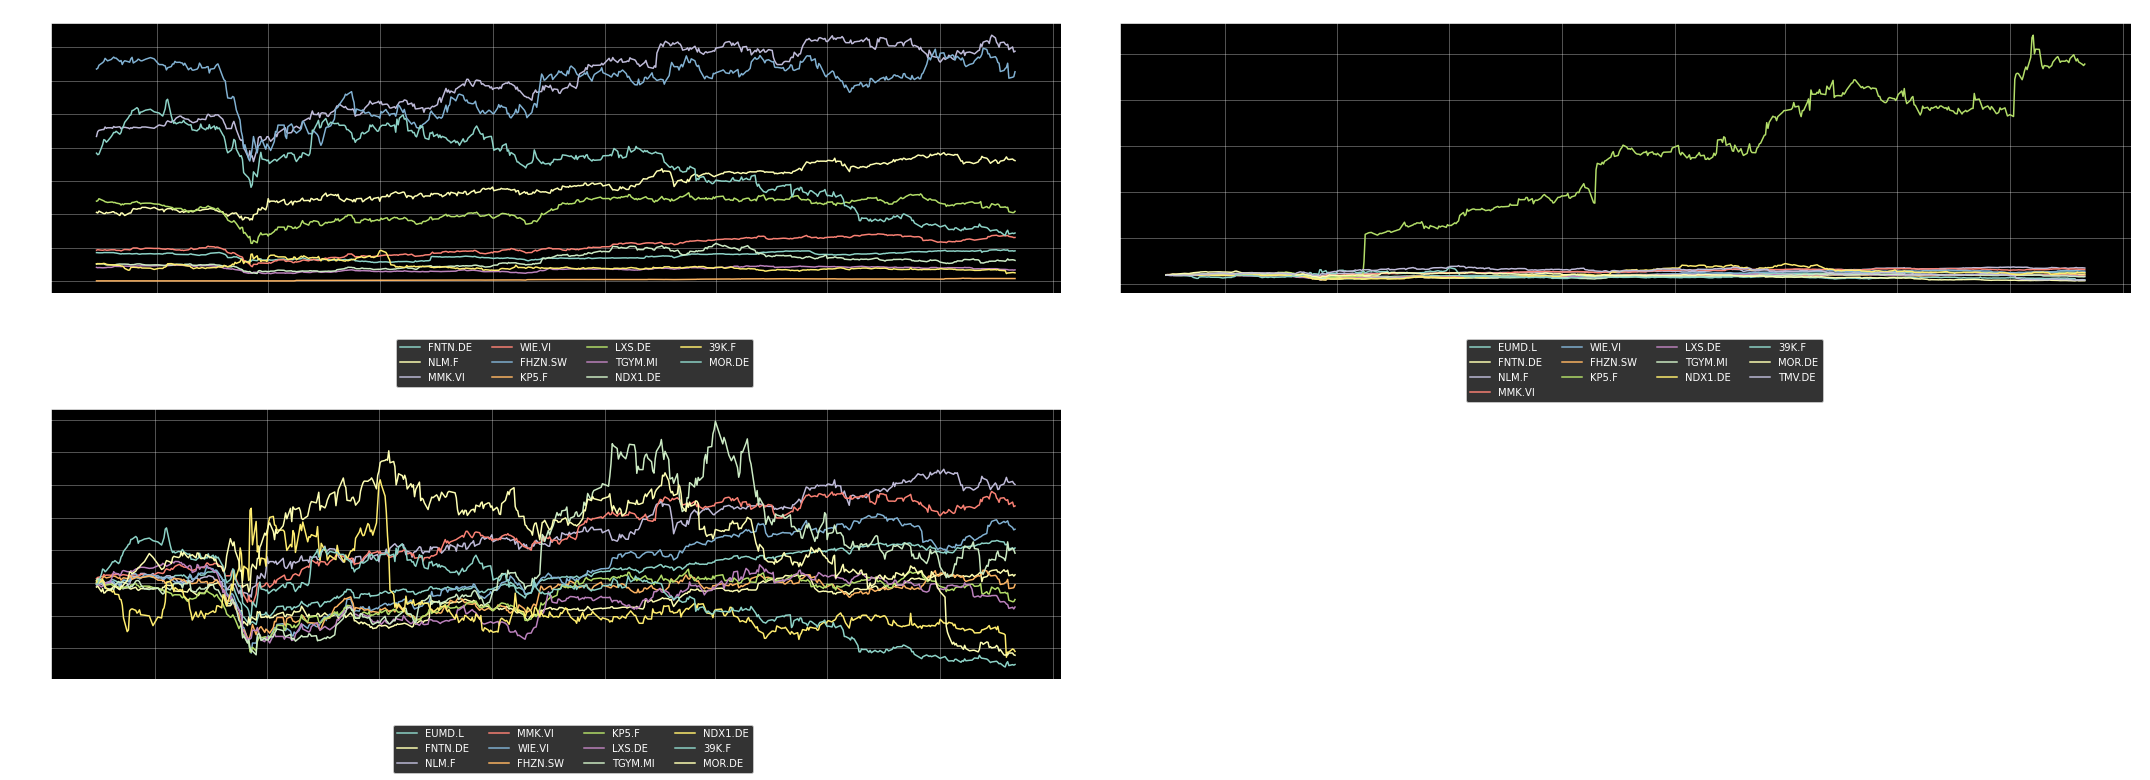

In [119]:
columns = data.columns
fig, ax = plt.subplots(figsize=(30,15))
plt.subplot(3,2,1)
for col in columns:
    plt.plot(data[col]) #Data plotted w/o the benchmark as it has to be scaled at times 
    plt.xlabel('Date')
    plt.ylabel('Stock Price in Currency stated on Yahoo Finance')
    plt.title('Stock Price development of the stocks within the portoflio - not scaled')
    plt.grid(alpha = 0.4)
    plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

columns = plot_data.columns
plt.subplot(3,2,2)
plt.plot((plot_data.pct_change() + 1).cumprod()) # value of 1€ invested in the beginning of the period 
plt.xlabel('Date')
plt.ylabel('Value of 1€')
plt.title('Value of 1€ invested in the beginning of the period ')
plt.grid(alpha = 0.4)
plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

#Removing outlier to see the returns better (if there are any)
plt.subplot(3,2,3)
plt.plot(((plot_data.loc[:, plot_data.columns!='KP5.F']).pct_change()+1).cumprod()) # value of 1€ invested in the beginning of the period 
plt.xlabel('Date')
plt.ylabel('Value of 1€')
plt.title('Value of 1€ invested in the beginning of the period w/o outliers')
plt.grid(alpha = 0.4)
plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

plt.tight_layout()

In [120]:
#creating the minimum volatility weight function to be used in the minvol algo
def calc_pypf_minvol_weights(prices):
    mu = mean_historical_return(prices, compounding= True)
    s  = risk_matrix(prices, method= "sample_cov")
    
    ef =  EfficientFrontier(mu, s)
    minvol_weights = ef.min_volatility()

    return minvol_weights

#create the weighminvol class to be used as an algo in the bt framework
class WeighMinVol(Algo):

    """
    Sets temp['weights'] based on minimum variance optimization.

    Sets the target weights based on calc_min_vol_weights.

    Args:
        * lookback (DateOffset): lookback period for estimating volatility
        * bounds ((min, max)): tuple specifying the min and max weights for
          each asset in the optimization.
        * covar_method (str): method used to estimate the covariance.
        * rf (float): risk-free rate used in optimization.

    Sets:
        * weights

    Requires:
        * selected
    """

    def __init__(
        self,
        lookback=pd.DateOffset(months=3),
        bounds=(0.0, 1.0),
        covar_method="ledoit-wolf",
        rf=0.0,
        lag=pd.DateOffset(days=0),
    ):
        super(WeighMinVol, self).__init__()
        self.lookback = lookback
        self.lag = lag
        self.bounds = bounds
        self.covar_method = covar_method
        self.rf = rf

    def __call__(self, target):
        selected = target.temp["selected"]

        if len(selected) == 0:
            target.temp["weights"] = {}
            return True

        if len(selected) == 1:
            target.temp["weights"] = {selected[0]: 1.0}
            return True

        t0 = target.now - self.lag
        prc = target.universe.loc[t0 - self.lookback : t0, selected]
        tw = calc_pypf_minvol_weights(prc)

        target.temp["weights"] = tw
        return True

In [121]:
strategy_meanvar = bt.Strategy('Strategy Maximum Sharpe Ratio', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighMeanVar(covar_method='standard'),
                    bt.algos.Rebalance()])

strategy_minvol = bt.Strategy('Strategy Minimum Volatility', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    WeighMinVol(covar_method='standard'),
                    bt.algos.Rebalance()])

strategy_1n =  bt.Strategy('Strategy 1/N', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighEqually(),
                    bt.algos.Rebalance()])

strategy_invvol =  bt.Strategy('Strategy Inverse Volatility', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighInvVol(),
                    bt.algos.Rebalance()])

strategy_erc =  bt.Strategy('Equal Risk Contribution', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighERC(covar_method='standard', risk_parity_method='ccd', maximum_iterations = 10000),
                    bt.algos.Rebalance()])



In [122]:
#Markowitz portfolio
backtest_meanvar = bt.Backtest(strategy_meanvar, data)
result_meanvar   = bt.run(backtest_meanvar)

#Minimum Volatility
backtest_minvol = bt.Backtest(strategy_minvol, data)
result_minvol   = bt.run(backtest_minvol)

#1/N portfolio
backtest_1n = bt.Backtest(strategy_1n, data)
result_1n   = bt.run(backtest_1n)

#Inverse Volatility 
backtest_invvol = bt.Backtest(strategy_invvol, data)
result_invvol = bt.run(backtest_invvol)

#Equal Risk Contribution 
backtest_erc = bt.Backtest(strategy_erc, data)
result_erc = bt.run(backtest_erc)


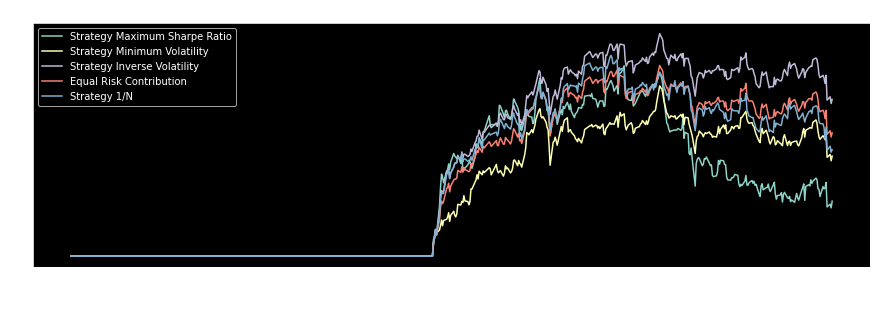

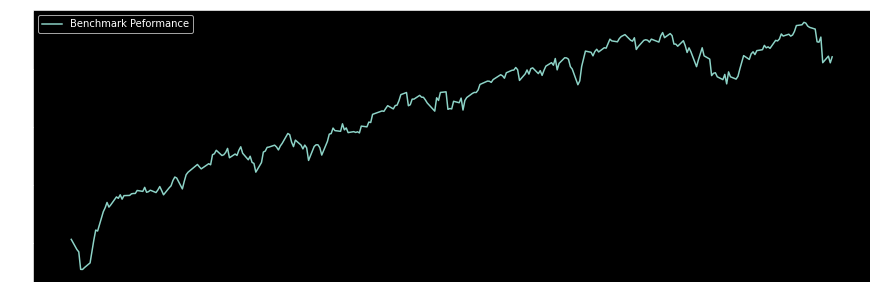

In [123]:
bt.run(backtest_meanvar, backtest_minvol, backtest_invvol, backtest_erc, backtest_1n).plot()

plt.figure(figsize=(15,5))
plt.plot((data_benchmark.pct_change()+1).cumprod()*100, label = 'Benchmark Peformance')
plt.legend()

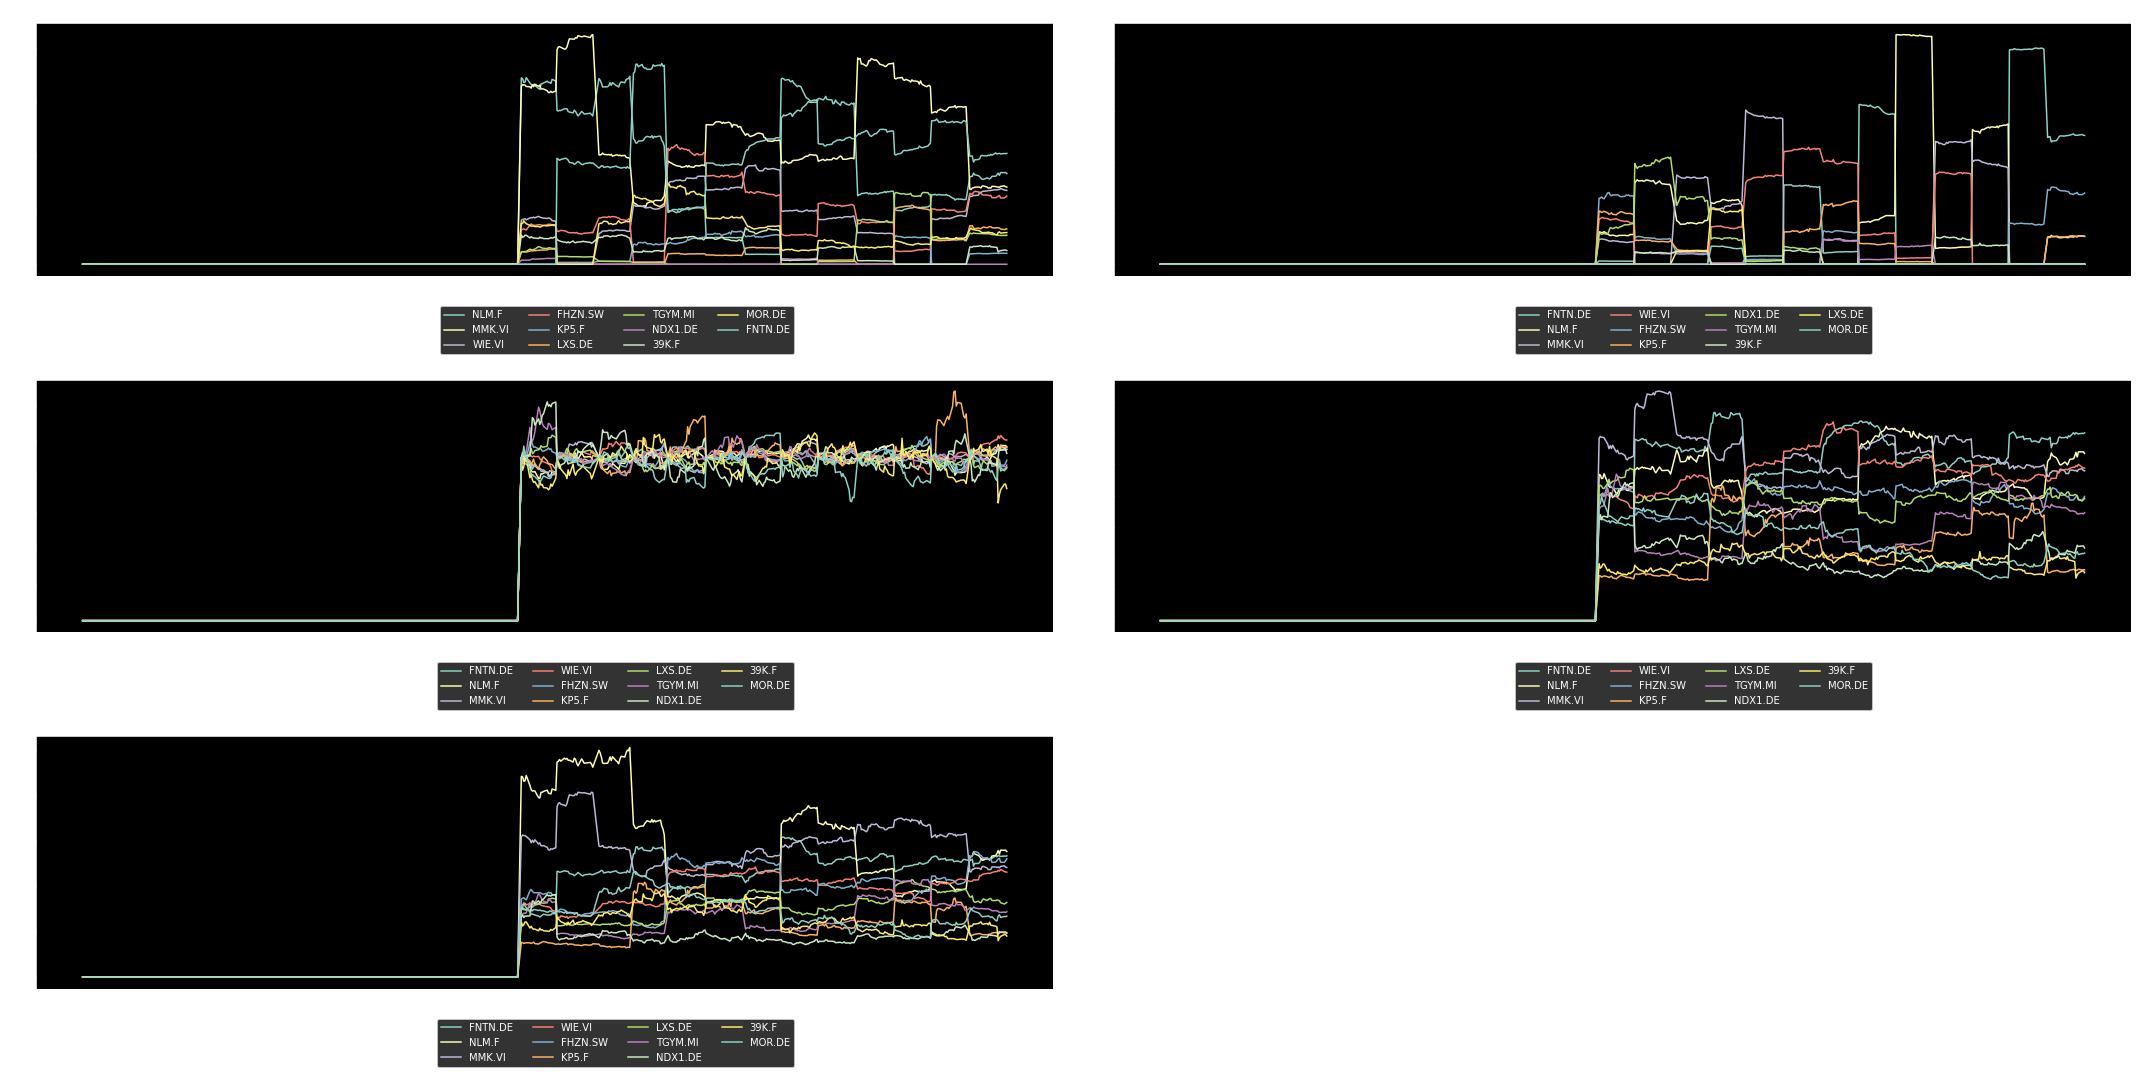

In [124]:
weights_meanvar = result_meanvar.get_security_weights()
weights_minvol = result_minvol.get_security_weights()
weights_1n = result_1n.get_security_weights()
weights_invvol = result_invvol.get_security_weights()
weights_erc = result_erc.get_security_weights()

#plotting the weights
fig, ax = plt.subplots(figsize=(30,15))

plt.subplot(3,2,1)
plt.plot(weights_minvol)
plt.title('MinVol Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_minvol.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))

plt.subplot(3,2,2)
plt.plot(weights_meanvar)
plt.title('MeanVar Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_meanvar.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))

plt.subplot(3,2,3)
plt.plot(weights_1n)
plt.title('1/N Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_1n.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))

plt.subplot(3,2,4)
plt.plot(weights_invvol)
plt.title('Inverse Volatility Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_invvol.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))

plt.subplot(3,2,5)
plt.plot(weights_erc)
plt.title('Equal Risk Contribution Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_erc.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))

plt.tight_layout()

In [130]:
def max_dd(total_r_series, days=250, minmin = True):
    """
    Maximum Draw-down during the last 12M
    """
    if minmin == True:
        roll_max = total_r_series.rolling(min_periods=1,window=days).max()

        daily_drawdown = total_r_series / roll_max - 1

        max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=days).min().min()

        return max_daily_drawdown
        
    else:
        roll_max = total_r_series.rolling(min_periods=1,window=days).max()

        daily_drawdown = total_r_series / roll_max - 1

        max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=days).min()

        return max_daily_drawdown

total_return_benchmark = (data_benchmark.pct_change()+1).cumprod().iloc[-1] - 1
std_benchmark = (data_benchmark.pct_change()).std() * np.sqrt((252))
mu_benchmark = mean_historical_return(data_benchmark, compounding= True)
sr_benchmark = mu_benchmark / std_benchmark
skew_benchmark = (data_benchmark.pct_change()).skew()
max_dd_benchmark = max_dd((data_benchmark.pct_change()+1).cumprod())
kurt_benchmark = (data_benchmark.pct_change()).kurt()

print("\nBenchmark's Total Return Factor: ", round(total_return_benchmark[-1],2), "\nBenchmark's Standard Deviation: ", round(std_benchmark[-1],4),
      "\nBenchmark's mean historical return: ", round(mu_benchmark[-1],4), "\nBenchmark's Sharpe Ratio", round(sr_benchmark[-1],2), 
      "\nBenchmark's return skewness", round(skew_benchmark[-1],4), "\nBencmark's maximum drawdown", round(max_dd_benchmark[-1],2), 
      "\nBenchmark's return kurtosis", round(kurt_benchmark[-1],4))


Benchmark's Total Return Factor:  0.32 
Benchmark's Standard Deviation:  0.1329 
Benchmark's mean historical return:  0.2836 
Benchmark's Sharpe Ratio 2.13 
Benchmark's return skewness -0.4804 
Bencmark's maximum drawdown -0.07 
Benchmark's return kurtosis 2.1325


In [126]:
results = pd.DataFrame()
results = pd.DataFrame(index = result_meanvar.stats.index)
results["Strategy MSR"] = result_meanvar.stats
results["Strategy MinVol"] = result_minvol.stats
results["Strategy InvVol"] = result_invvol.stats
results["Equal Risk Contribution"] = result_erc.stats
results["Strategy 1/N"] = result_1n.stats
results

,Strategy MSR,Strategy MinVol,Strategy InvVol,Equal Risk Contribution,Strategy 1/N
start,2019-11-12 00:00:00,2019-11-12 00:00:00,2019-11-12 00:00:00,2019-11-12 00:00:00,2019-11-12 00:00:00
end,2021-12-01 00:00:00,2021-12-01 00:00:00,2021-12-01 00:00:00,2021-12-01 00:00:00,2021-12-01 00:00:00
rf,0.0,0.0,0.0,0.0,0.0
total_return,0.104352,0.189877,0.297204,0.233707,0.201941
cagr,0.049527,0.088352,0.135102,0.107695,0.093712
max_drawdown,-0.197892,-0.107231,-0.09316,-0.099526,-0.132912
calmar,0.250271,0.823943,1.450212,1.082081,0.705072
mtd,0.011614,0.007468,0.005909,0.006132,0.003898
three_month,-0.024358,-0.042786,-0.04318,-0.048775,-0.061294
six_month,-0.15706,-0.053269,-0.058209,-0.062991,-0.09347


In [131]:
result_invvol.get_transactions().tail(10)

price  quantity
Date       Security                      
2021-11-01 FHZN.SW   167.800003      98.0
           FNTN.DE    22.660000    -116.0
           KP5.F       1.812000  -33329.0
           LXS.DE     58.400002     151.0
           MMK.VI    172.600006     -76.0
           MOR.DE     40.419998     416.0
           NDX1.DE    15.850000    -894.0
           NLM.F      89.199997     421.0
           TGYM.MI     9.170000     155.0
           WIE.VI     31.020000    -222.0

In [133]:
result_invvol.get_security_weights().tail(10)

,FNTN.DE,NLM.F,MMK.VI,WIE.VI,FHZN.SW,KP5.F,LXS.DE,TGYM.MI,NDX1.DE,39K.F,MOR.DE
2021-11-18,0.147765,0.126295,0.117530,0.121099,0.099648,0.039488,0.102819,0.088643,0.055136,0.048449,0.052852
2021-11-19,0.146956,0.128879,0.120355,0.121722,0.096299,0.040400,0.100275,0.087636,0.055350,0.048365,0.053486
2021-11-22,0.150187,0.129307,0.120222,0.122760,0.096466,0.040952,0.100049,0.087645,0.054438,0.047536,0.050161
2021-11-23,0.148961,0.131526,0.119740,0.122506,0.097696,0.040506,0.100869,0.087326,0.053843,0.047049,0.049699
2021-11-24,0.150168,0.134561,0.120115,0.123884,0.098940,0.040295,0.100509,0.086727,0.056649,0.033978,0.053893
2021-11-25,0.149720,0.130721,0.119133,0.123106,0.099755,0.040217,0.099820,0.085275,0.060216,0.036618,0.055142
2021-11-26,0.149183,0.134884,0.120683,0.124965,0.096289,0.041102,0.097194,0.085308,0.059239,0.038013,0.052851
2021-11-29,0.149726,0.134828,0.121491,0.122580,0.096269,0.040462,0.095535,0.085728,0.059744,0.039707,0.053644
2021-11-30,0.149526,0.134960,0.120026,0.122204,0.097470,0.040636,0.096549,0.085263,0.059762,0.039718,0.053598
2021-12-01,0.150042,0.133575,0.119738,0.121935,0.099239,0.040664,0.097741,0.086321,0.058130,0.038355,0.053973
